In [1]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pachner_traversal.utils import compute_rhat, data_path, set_style

set_style()

In [2]:
mcmc_result_path = data_path / "results" / "mcmc" / "generic_samples" / "20251004_1845"
assert mcmc_result_path.exists()

In [3]:
tet_map = {
    l: i for i, l in enumerate("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ")
}

In [4]:
metrics = [
    "agg_score_alex_norm",
    "agg_score_alex_deg",
    "agg_score_alex_det",
    "agg_score_edge_var",
    "agg_score_num_gen",
]

for metric in metrics:
    df = pd.read_csv(mcmc_result_path / f"{metric}_chains.csv", index_col=0)
    rhat, ess = compute_rhat(df)
    print(f"{metric:20} & {rhat:.3f} & {ess:,.0f} \\\\")

agg_score_alex_norm  & 1.003 & 69,540 \\
agg_score_alex_deg   & 1.004 & 69,500 \\
agg_score_alex_det   & 1.005 & 69,319 \\
agg_score_edge_var   & 1.006 & 69,131 \\
agg_score_num_gen    & 1.009 & 68,769 \\


In [5]:
res = {}

for metric in metrics:
    res[metric] = pd.read_csv(mcmc_result_path / f"{metric}_chains.csv", index_col=0).values.flatten()

In [6]:
import seaborn as sns

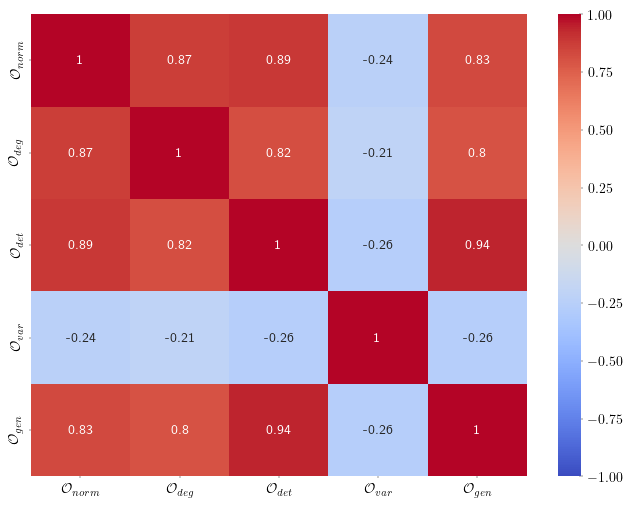

In [93]:
corr = pd.DataFrame(res).corr()

corr.columns = [r'$\mathcal{O}_{norm}$', r'$\mathcal{O}_{deg}$', r'$\mathcal{O}_{det}$', r'$\mathcal{O}_{var}$', r'$\mathcal{O}_{gen}$']
corr.index = [r'$\mathcal{O}_{norm}$', r'$\mathcal{O}_{deg}$', r'$\mathcal{O}_{det}$', r'$\mathcal{O}_{var}$', r'$\mathcal{O}_{gen}$']

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    vmin=-1,  # Set the minimum of the color bar to -1
    vmax=1,
)


plt.savefig(data_path.parent / 'thesis' / 'figures' / 'obj_correlation.pdf', bbox_inches="tight")

plt.show()

In [8]:
def fit_alpha(all_data, x_min):
    data = all_data[all_data >= x_min]

    n = len(data)
    sum_log = np.sum(np.log(data / x_min))
    alpha = 1 + n / sum_log
    try:
        return alpha, (alpha - 1) * x_min ** (alpha - 1)
    except:
        raise ValueError(f"Invalid x_min: {x_min}, alpha: {alpha}")

def get_area(bin_start, bin_end, alpha, C):
    return C * (bin_end ** (1 - alpha) - bin_start ** (1 - alpha)) / (1 - alpha)

def get_samps_exceed(alpha, x_min, threshold):
    return (threshold / x_min) ** (alpha-1)

def cdf(x, alpha, x_min):
    return 1 - (x/x_min)**(1 - alpha)

def get_ks_stat(all_data, x_min):
    alpha, C = fit_alpha(all_data, x_min)
    data = all_data[all_data >= x_min]
    data = np.sort(data)
    emp_cdf = np.arange(1, len(data)+1) / len(data)

    return np.max(np.abs(cdf(data, alpha, x_min) - emp_cdf))

def get_xmin(data):
    candidate_xmins = np.sort(np.unique(data))[:-10]  # avoid very high xmins
    ks_stats = [get_ks_stat(data, x_min) for x_min in candidate_xmins]
    x_min = candidate_xmins[np.argmin(ks_stats)]
    return x_min

In [9]:
def extract_data(tet_30_scores, use_min=False):
    data = tet_30_scores
    data = data[data > 0]

    if use_min:
        x_min = get_xmin(data)
    else:
        x_min = data.min()
    sub_data = data[data >= x_min]

    alpha, C = fit_alpha(sub_data, x_min)
    C = C * len(sub_data) / len(data)

    min_val = np.min(data)
    max_val = np.max(data)
    log_bins = np.logspace(np.log10(min_val), np.log10(max_val), num=20)

    counts, bin_edges = np.histogram(data, bins=log_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = bin_edges[1:] - bin_edges[:-1]
    counts = counts / (len(data) * bin_width)

    non_zero_indices = counts > 0
    x_values = bin_centers[non_zero_indices]
    y_values = counts[non_zero_indices]

    return sub_data, C, alpha, counts, bin_edges, x_min

In [10]:
def test_stat_sig(tet_30_scores):
    data = tet_30_scores[tet_30_scores > 0]
    x_min = get_xmin(data)
    alpha, C = fit_alpha(data, x_min)
    N = (data >= x_min).sum()
    actual_ks = get_ks_stat(data, x_min)

    samp_data = lambda: (np.random.pareto(alpha, N) + 1) * x_min

    kss = []

    for _ in range(1000):
        samps = samp_data()
        x_min_samp = get_xmin(samps)
        ks = get_ks_stat(samps, x_min_samp)
        kss.append(ks)

    return actual_ks, kss

In [85]:
def generate_plot(tet_30_scores, save_name):
    data, C, alpha, counts, bin_edges, x_min = extract_data(tet_30_scores)
    data_min, C_min, alpha_min, counts_min, bin_edges_min, x_min_min = extract_data(tet_30_scores, use_min=True)

    p_gt_xmin = tet_30_scores[tet_30_scores >= x_min].shape[0] / tet_30_scores.shape[0]
    p_gt_xmin_min = tet_30_scores[tet_30_scores >= x_min_min].shape[0] / tet_30_scores.shape[0]

    fig, ax = plt.subplots(figsize=(8, 6))

    # ax.plot(np.sort(np.r_[data]), p_gt_xmin*C * np.sort(np.r_[data]) ** (-alpha), color="red", ls="--")
    # ax.plot(np.sort(np.r_[data_min]), p_gt_xmin_min*C_min * np.sort(np.r_[data_min]) ** (-alpha_min), color="orange", ls="--")

    params_lognorm = stats.lognorm.fit(tet_30_scores, floc=0)

    plt.plot(
        np.sort(tet_30_scores),
        stats.lognorm.pdf(np.sort(tet_30_scores), params_lognorm[0], loc=0, scale=params_lognorm[2]),
        color="red",
        ls="--",
    )

    true_area = 0

    for i in range(len(counts)):
        bin_start = bin_edges[i]
        bin_end = bin_edges[i + 1]
        bin_height = counts[i]

        rect = patches.Rectangle(
            (bin_start, 0),
            bin_end - bin_start,
            bin_height,
            linewidth=0.5,
            edgecolor="black",
            facecolor="C0",
        )
        ax.add_patch(rect)


    scale = 1.1
    x_min = np.max(bin_edges) * (1 - scale) / 2 + np.min(bin_edges) * (1 + scale) / 2
    x_max = np.max(bin_edges) * (1 + scale) / 2 + np.min(bin_edges) * (1 - scale) / 2
    y_min = np.max(counts) * (1 - scale) / 2
    y_max = np.max(counts) * (1 + scale) / 2


    # ax.set_xlim(x_min, x_max)
    # ax.set_ylim(0, y_max)
    plt.legend(["Log-normal fit", "Empirical distribution"])

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Value")
    plt.ylabel("Density")
    # plt.axvline(reached_score, color="green", ls="--")
    plt.savefig(data_path.parent / 'thesis' / 'figures' / save_name, bbox_inches="tight")
    plt.show()

In [28]:
isos_df = pd.read_csv(mcmc_result_path / "isos_lists.csv")
tet_30_filter = isos_df.map(lambda x: x.startswith("E")).values.flatten()

achieved_direct = {
    "agg_score_alex_deg": 152.26,
    "agg_score_alex_det": 27.19,
    "agg_score_alex_norm": 29.06,
    "agg_score_num_gen": 1.94,
}

achieved_sim = {
    "agg_score_alex_deg": 433.42,
    "agg_score_alex_det": 13.84,
    "agg_score_alex_norm": 152.26,
    "agg_score_num_gen": 2.65,
}

for metric in achieved_direct:
    score_df = pd.read_csv(mcmc_result_path / f"{metric}_chains.csv", index_col=0)
    tet_30_scores = score_df.values.flatten()[tet_30_filter]
    data_min, C_min, alpha_min, counts_min, bin_edges_min, x_min_min = extract_data(tet_30_scores, use_min=True)

    p_gt_xmin = tet_30_scores[tet_30_scores >= x_min_min].shape[0] / tet_30_scores.shape[0]
    p_exc = 1/get_samps_exceed(alpha_min, x_min_min, achieved_direct[metric])

    p_ach = p_exc * p_gt_xmin

    print(metric, f'{p_ach:.2e}')



agg_score_alex_deg 1.21e-05
agg_score_alex_det 2.62e-13
agg_score_alex_norm 3.29e-06
agg_score_num_gen 2.32e-05


In [30]:
score_df = pd.read_csv(mcmc_result_path / f"agg_score_edge_var_chains.csv", index_col=0)
tet_30_scores = score_df.values.flatten()[tet_30_filter]

In [34]:
from scipy import stats

In [69]:
params = stats.lognorm.fit(tet_30_scores, floc=0)

In [ ]:
params_gamma = stats.gamma.fit(tet_30_scores, floc=0)

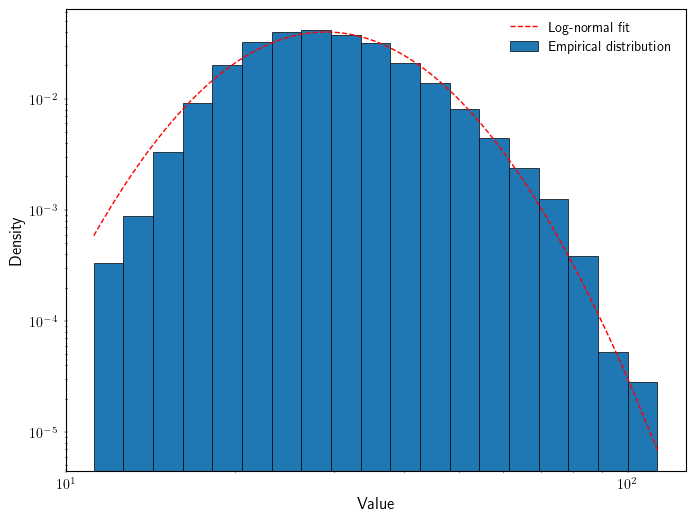

In [86]:
isos_df = pd.read_csv(mcmc_result_path / "isos_lists.csv")
tet_30_filter = isos_df.map(lambda x: x.startswith("E")).values.flatten()

for metric in [metrics[3]]:
    score_df = pd.read_csv(mcmc_result_path / f"{metric}_chains.csv", index_col=0)
    tet_30_scores = score_df.values.flatten()[tet_30_filter]

    generate_plot(tet_30_scores, f"{metric}_log_distribution.pdf")